# Block 1: Environment Setup & Imports


In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras import mixed_precision
import numpy as np
import matplotlib.pyplot as plt
import os
import gc

# Check GPU availability
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Set memory growth for GPU (critical for ResNet-152)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print(e)

# Enable mixed precision for memory efficiency
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print(f'Mixed precision policy: {policy.name}')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Clear any existing models from memory
keras.backend.clear_session()
gc.collect()

2026-02-03 07:18:38.579955: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770103118.788242      23 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770103118.850313      23 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770103119.368488      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770103119.368533      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770103119.368535      23 computation_placer.cc:177] computation placer alr

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU memory growth enabled
Mixed precision policy: mixed_float16


0

# Block 2: Data Loading & Preprocessing


In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert labels to categorical
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step
Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 10)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 10)


# Block 3: Data Augmentation Setup


In [3]:
# Advanced data augmentation for very deep model
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.125,
    height_shift_range=0.125,
    horizontal_flip=True,
    zoom_range=0.15,
    shear_range=0.1,
    fill_mode='nearest'
)

# No augmentation for validation/test
test_datagen = ImageDataGenerator()

# Create data generators
batch_size = 128  # Adjust if memory issues occur
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
test_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size, shuffle=False)

print(f"Batch size: {batch_size}")
print(f"Training batches per epoch: {len(x_train) // batch_size}")

Batch size: 128
Training batches per epoch: 390


# Block 4: Bottleneck Block Implementation 


In [4]:
def bottleneck_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True, name=None):
    """
    A bottleneck block for ResNet-50/101/152
    
    Args:
        x: input tensor
        filters: number of filters in the bottleneck layer (3x3 conv)
        kernel_size: kernel size for middle convolution (default 3)
        stride: stride for middle convolution
        conv_shortcut: use convolution for shortcut (True) or identity (False)
        name: block label
    """
    bn_axis = 3  # Channel axis for 'channels_last'
    
    if conv_shortcut:
        shortcut = layers.Conv2D(4 * filters, 1, strides=stride, name=name + '_0_conv')(x)
        shortcut = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_0_bn')(shortcut)
    else:
        shortcut = x
    
    # First 1x1 convolution (dimensionality reduction)
    x = layers.Conv2D(filters, 1, strides=1, use_bias=False, name=name + '_1_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_1_bn')(x)
    x = layers.Activation('relu', name=name + '_1_relu')(x)
    
    # Second 3x3 convolution (main processing)
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same',
                      use_bias=False, name=name + '_2_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_2_bn')(x)
    x = layers.Activation('relu', name=name + '_2_relu')(x)
    
    # Third 1x1 convolution (dimensionality expansion)
    x = layers.Conv2D(4 * filters, 1, use_bias=False, name=name + '_3_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_3_bn')(x)
    
    # Add shortcut connection
    x = layers.Add(name=name + '_add')([shortcut, x])
    x = layers.Activation('relu', name=name + '_out')(x)
    
    return x

# Block 5: ResNet-152 Architecture


In [5]:
def ResNet152(input_shape=(32, 32, 3), num_classes=10, dropout_rate=0.5):
    """
    ResNet-152 architecture adapted for CIFAR-10
    
    Architecture using Bottleneck blocks:
    - conv1: 1 layer
    - conv2_x: 3 bottleneck blocks (64 filters → 256 output)
    - conv3_x: 8 bottleneck blocks (128 filters → 512 output) ← Deeper!
    - conv4_x: 36 bottleneck blocks (256 filters → 1024 output) ← Much deeper!
    - conv5_x: 3 bottleneck blocks (512 filters → 2048 output)
    Total: 152 layers
    
    Layer counting: 1 (conv1) + 3*3 + 8*3 + 36*3 + 3*3 + 1 (fc) = 152 layers
    """
    inputs = layers.Input(shape=input_shape)
    
    # Initial convolution (adapted for CIFAR-10)
    x = layers.Conv2D(64, 3, strides=1, padding='same', use_bias=False, name='conv1_conv')(inputs)
    x = layers.BatchNormalization(axis=3, epsilon=1.001e-5, name='conv1_bn')(x)
    x = layers.Activation('relu', name='conv1_relu')(x)
    # Note: No MaxPooling for CIFAR-10 due to small image size
    
    # Stage 1 (conv2_x): 3 bottleneck blocks with 64 filters (output: 256 channels)
    x = bottleneck_block(x, 64, conv_shortcut=True, name='conv2_block1')
    x = bottleneck_block(x, 64, conv_shortcut=False, name='conv2_block2')
    x = bottleneck_block(x, 64, conv_shortcut=False, name='conv2_block3')
    
    # Stage 2 (conv3_x): 8 bottleneck blocks with 128 filters (output: 512 channels)
    # This is deeper than ResNet-101 (which has 4)!
    x = bottleneck_block(x, 128, stride=2, conv_shortcut=True, name='conv3_block1')
    for i in range(2, 9):  # blocks 2 through 8
        x = bottleneck_block(x, 128, conv_shortcut=False, name=f'conv3_block{i}')
    
    # Stage 3 (conv4_x): 36 bottleneck blocks with 256 filters (output: 1024 channels)
    # This is MUCH deeper than ResNet-101 (which has 23)!
    x = bottleneck_block(x, 256, stride=2, conv_shortcut=True, name='conv4_block1')
    for i in range(2, 37):  # blocks 2 through 36
        x = bottleneck_block(x, 256, conv_shortcut=False, name=f'conv4_block{i}')
    
    # Stage 4 (conv5_x): 3 bottleneck blocks with 512 filters (output: 2048 channels)
    x = bottleneck_block(x, 512, stride=2, conv_shortcut=True, name='conv5_block1')
    x = bottleneck_block(x, 512, conv_shortcut=False, name='conv5_block2')
    x = bottleneck_block(x, 512, conv_shortcut=False, name='conv5_block3')
    
    # Global Average Pooling
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    
    # Dropout for regularization (critical for very deep networks)
    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate, name='dropout')(x)
    
    # Fully connected layer
    outputs = layers.Dense(num_classes, activation='softmax', dtype='float32', name='predictions')(x)
    
    # Create model
    model = models.Model(inputs, outputs, name='resnet152')
    
    return model

# Block 6: Model Creation & Summary


In [6]:
# Create the model
print("=" * 80)
print("Creating ResNet-152 model... (This will take a moment)")
print("=" * 80)

model = ResNet152(input_shape=(32, 32, 3), num_classes=10, dropout_rate=0.5)

# Display abbreviated model summary
print("\nModel Summary (abbreviated):")
print("=" * 80)

# Count layers by type
conv_layers = len([l for l in model.layers if 'conv' in l.name.lower()])
bn_layers = len([l for l in model.layers if 'bn' in l.name.lower()])
activation_layers = len([l for l in model.layers if 'relu' in l.name.lower() or 'activation' in l.name.lower()])

print(f"Total layers: {len(model.layers)}")
print(f"Convolutional layers: {conv_layers}")
print(f"Batch Normalization layers: {bn_layers}")
print(f"Activation layers: {activation_layers}")

# Count total parameters
total_params = model.count_params()
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
non_trainable_params = sum([tf.size(w).numpy() for w in model.non_trainable_weights])

print("\n" + "=" * 80)
print("ResNet-152 Model Statistics")
print("=" * 80)
print(f"Total parameters:          {total_params:>15,}")
print(f"Trainable parameters:      {trainable_params:>15,}")
print(f"Non-trainable parameters:  {non_trainable_params:>15,}")
print(f"Model size (approx):       {total_params * 4 / (1024**2):>12.2f} MB (FP32)")
print(f"Model size (mixed prec):   {total_params * 2 / (1024**2):>12.2f} MB (FP16)")
print("=" * 80)

# Optional: Print full summary (warning: very long!)
model.summary()

Creating ResNet-152 model... (This will take a moment)


I0000 00:00:1770103153.412523      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



Model Summary (abbreviated):
Total layers: 515
Convolutional layers: 511
Batch Normalization layers: 155
Activation layers: 101

ResNet-152 Model Statistics
Total parameters:               58,311,882
Trainable parameters:           58,160,458
Non-trainable parameters:          151,424
Model size (approx):             222.44 MB (FP32)
Model size (mixed prec):         111.22 MB (FP16)


Model: "resnet152"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 32, 32,    │      1,728 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 32, 32,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 32, 32,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,096 │ conv1_relu[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ conv1_relu[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,384 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_add    │ (None, 32, 32,    │          0 │ conv2_block1_0_b… │
│ (Add)               │ 256)              │            │ conv2_block1_3_b… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 32, 32,    │          0 │ conv2_block1_add… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 32, 32,    │     16,384 │ conv2_block1_out

 Total params: 58,311,882 (222.44 MB)

 Trainable params: 58,160,458 (221.86 MB)

 Non-trainable params: 151,424 (591.50 KB)

# Block 7: Compile Model with Advanced Settings


In [7]:
# Label smoothing loss for better generalization
class LabelSmoothingCategoricalCrossentropy(keras.losses.Loss):
    def __init__(self, smoothing=0.1, **kwargs):
        super().__init__(**kwargs)
        self.smoothing = smoothing
    
    def call(self, y_true, y_pred):
        num_classes = tf.cast(tf.shape(y_true)[-1], y_pred.dtype)
        y_true = y_true * (1.0 - self.smoothing) + (self.smoothing / num_classes)
        return keras.losses.categorical_crossentropy(y_true, y_pred)

# Cosine decay with warmup (with proper serialization)
class WarmUpCosineDecay(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, decay_steps, warmup_steps, alpha=0.0):
        super().__init__()
        self.initial_learning_rate = initial_learning_rate
        self.decay_steps = decay_steps
        self.warmup_steps = warmup_steps
        self.alpha = alpha
        
    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        decay_steps = tf.cast(self.decay_steps, tf.float32)
        
        # Warmup phase
        warmup_lr = self.initial_learning_rate * (step / warmup_steps)
        
        # Cosine decay phase
        completed_fraction = (step - warmup_steps) / (decay_steps - warmup_steps)
        completed_fraction = tf.clip_by_value(completed_fraction, 0.0, 1.0)
        cosine_decayed = 0.5 * (1.0 + tf.cos(np.pi * completed_fraction))
        decay_lr = (self.initial_learning_rate - self.alpha) * cosine_decayed + self.alpha
        
        # Choose based on step
        return tf.where(step < warmup_steps, warmup_lr, decay_lr)
    
    def get_config(self):
        return {
            'initial_learning_rate': self.initial_learning_rate,
            'decay_steps': self.decay_steps,
            'warmup_steps': self.warmup_steps,
            'alpha': self.alpha
        }

# Training parameters
initial_learning_rate = 0.1
epochs = 250  # More epochs for deeper model
steps_per_epoch = len(x_train) // batch_size
total_steps = epochs * steps_per_epoch
warmup_steps = 5 * steps_per_epoch  # 5 epochs warmup

# Create learning rate schedule
lr_schedule = WarmUpCosineDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=total_steps,
    warmup_steps=warmup_steps,
    alpha=1e-6
)

# Compile model
model.compile(
    optimizer=optimizers.SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True),
    loss=LabelSmoothingCategoricalCrossentropy(smoothing=0.1),
    metrics=['accuracy']
)

print("\n" + "=" * 80)
print("Model Compiled Successfully")
print("=" * 80)
print(f"Optimizer:           SGD with Nesterov momentum (0.9)")
print(f"Learning rate:       Warmup + Cosine decay")
print(f"  - Initial LR:      {initial_learning_rate}")
print(f"  - Warmup steps:    {warmup_steps} ({warmup_steps//steps_per_epoch} epochs)")
print(f"  - Min LR:          1e-6")
print(f"Loss:                Categorical crossentropy + label smoothing (0.1)")
print(f"Mixed precision:     Enabled (FP16)")
print(f"Total epochs:        {epochs}")
print(f"Total steps:         {total_steps:,}")
print("=" * 80)


Model Compiled Successfully
Optimizer:           SGD with Nesterov momentum (0.9)
Learning rate:       Warmup + Cosine decay
  - Initial LR:      0.1
  - Warmup steps:    1950 (5 epochs)
  - Min LR:          1e-6
Loss:                Categorical crossentropy + label smoothing (0.1)
Mixed precision:     Enabled (FP16)
Total epochs:        250
Total steps:         97,500


# Block 8: Callbacks Setup


In [8]:
# Create directory for saving models
os.makedirs('./models', exist_ok=True)
os.makedirs('./logs', exist_ok=True)

# Model checkpoint - save best model
checkpoint = ModelCheckpoint(
    './models/resnet152_cifar10_best.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_weights_only=False
)

# Reduce learning rate on plateau (backup to cosine schedule)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-7,
    verbose=1
)

# Early stopping with generous patience for very deep model
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True,
    verbose=1
)

# TensorBoard for monitoring
from datetime import datetime
log_dir = f"./logs/resnet152_{datetime.now().strftime('%Y%m%d-%H%M%S')}"
tensorboard = keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    update_freq='epoch',
    profile_batch=0  # Disable profiling to save memory
)

# Custom callback to log learning rate and save periodic checkpoints
class DetailedLogger(keras.callbacks.Callback):
    def __init__(self, save_freq=25):
        super().__init__()
        self.epoch_times = []
        self.save_freq = save_freq
        
    def on_epoch_begin(self, epoch, logs=None):
        import time
        self.epoch_start_time = time.time()
        
    def on_epoch_end(self, epoch, logs=None):
        import time
        epoch_time = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_time)
        
        lr = self.model.optimizer.learning_rate
        if isinstance(lr, keras.optimizers.schedules.LearningRateSchedule):
            lr = lr(self.model.optimizer.iterations)
        logs['learning_rate'] = lr
        
        # Save periodic checkpoint
        if (epoch + 1) % self.save_freq == 0:
            val_acc = logs.get('val_accuracy', 0)
            checkpoint_path = f'./models/resnet152_epoch_{epoch+1:03d}_acc_{val_acc:.4f}.keras'
            self.model.save(checkpoint_path)
            print(f'\n  → Checkpoint saved: {checkpoint_path}')
        
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            avg_time = np.mean(self.epoch_times[-10:])
            remaining_epochs = 250 - (epoch + 1)
            eta_minutes = (remaining_epochs * avg_time) / 60
            print(f'\nEpoch {epoch+1}: LR = {float(lr):.6f}, '
                  f'Time = {epoch_time:.1f}s, ETA = {eta_minutes:.1f} min')

detailed_logger = DetailedLogger(save_freq=25)

callbacks = [checkpoint, early_stop, tensorboard, detailed_logger]

print("Callbacks configured successfully!")
print(f"TensorBoard logs: {log_dir}")
print(f"Checkpoints saved to: ./models/")
print(f"Periodic checkpoints: Every 25 epochs")

Callbacks configured successfully!
TensorBoard logs: ./logs/resnet152_20260203-071917
Checkpoints saved to: ./models/
Periodic checkpoints: Every 25 epochs


# Block 9: Training


In [9]:
# Training
print("\n" + "=" * 80)
print("Starting ResNet-152 Training")
print("=" * 80)
print(f"Batch size:          {batch_size}")
print(f"Steps per epoch:     {steps_per_epoch}")
print(f"Total epochs:        {epochs}")
print(f"Total steps:         {total_steps:,}")
print(f"Warmup epochs:       {warmup_steps // steps_per_epoch}")
print(f"Est. time (P100):    ~3-4 hours")
print("=" * 80)
print("\nNOTE: This is a very deep model. Training will take significant time.")
print("Consider reducing epochs or using gradient checkpointing if memory issues occur.")
print("=" * 80)

# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=(x_test, y_test),
    callbacks=callbacks,
    verbose=1
)

print("\n" + "=" * 80)
print("Training completed!")
print("=" * 80)


Starting ResNet-152 Training
Batch size:          128
Steps per epoch:     390
Total epochs:        250
Total steps:         97,500
Warmup epochs:       5
Est. time (P100):    ~3-4 hours

NOTE: This is a very deep model. Training will take significant time.
Consider reducing epochs or using gradient checkpointing if memory issues occur.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/250


I0000 00:00:1770103201.694773      63 service.cc:152] XLA service 0x7ee12c0025e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770103201.694826      63 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1770103208.620723      63 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1770103244.803018      63 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.1806 - loss: 2.7866
Epoch 1: val_accuracy improved from -inf to 0.28730, saving model to ./models/resnet152_cifar10_best.keras
390/390 ━━━━━━━━━━━━━━━━━━━━ 350s 674ms/step - accuracy: 0.1808 - loss: 2.7861 - val_accuracy: 0.2873 - val_loss: 2.3277 - learning_rate: 0.0200
Epoch 2/250
  1/390 ━━━━━━━━━━━━━━━━━━━━ 3:06 481ms/step - accuracy: 0.3594 - loss: 1.8375

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.28730 to 0.29480, saving model to ./models/resnet152_cifar10_best.keras
390/390 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - accuracy: 0.3594 - loss: 1.8375 - val_accuracy: 0.2948 - val_loss: 2.2583 - learning_rate: 0.0201
Epoch 3/250
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.3642 - loss: 2.0854
Epoch 3: val_accuracy did not improve from 0.29480
390/390 ━━━━━━━━━━━━━━━━━━━━ 203s 521ms/step - accuracy: 0.3642 - loss: 2.0853 - val_accuracy: 0.2410 - val_loss: 2.3869 - learning_rate: 0.0401
Epoch 4/250
  1/390 ━━━━━━━━━━━━━━━━━━━━ 3:00 464ms/step - accuracy: 0.2969 - loss: 1.9546
Epoch 4: val_accuracy did not improve from 0.29480
390/390 ━━━━━━━━━━━━━━━━━━━━ 27s 68ms/step - accuracy: 0.2969 - loss: 1.9546 - val_accuracy: 0.2150 - val_loss: 2.5957 - learning_rate: 0.0401
Epoch 5/250
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.4151 - loss: 1.9082
Epoch 5: val_accuracy improved from 0.29480 to 0.40870, saving model to ./models/resnet

# Block 10: Training History Visualization


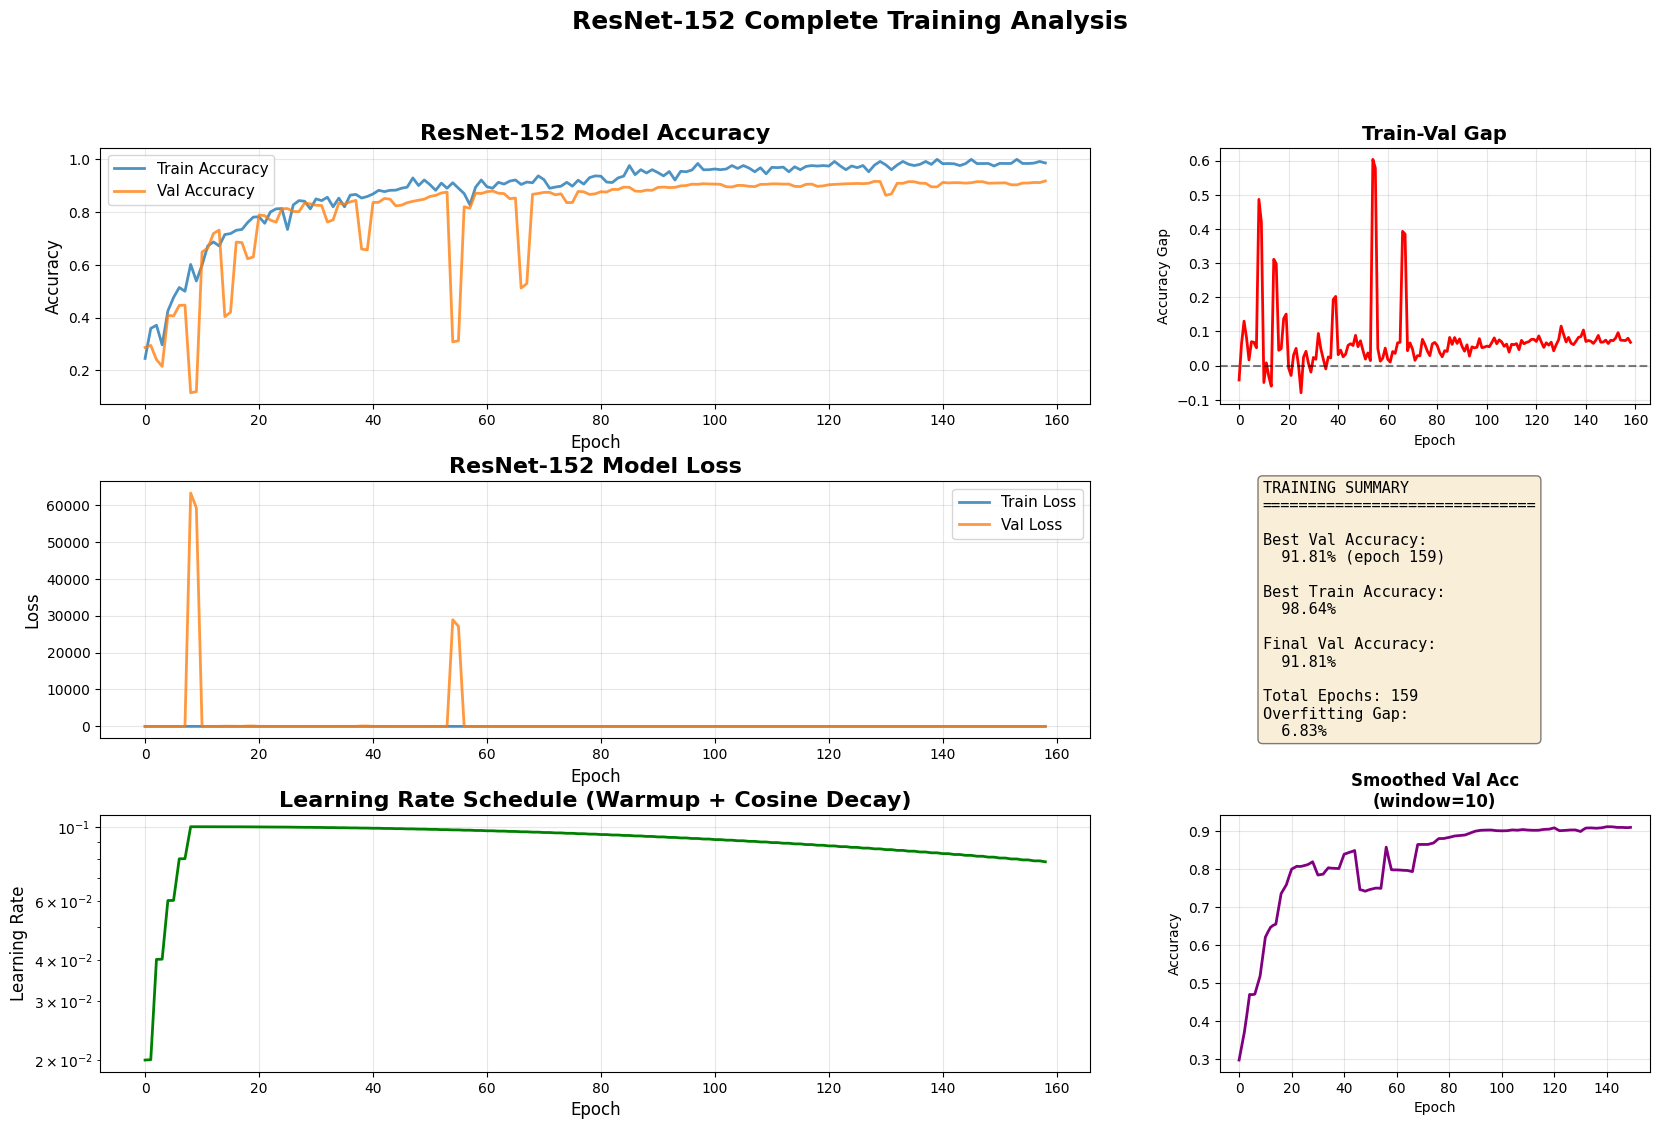

In [10]:
# Comprehensive training history visualization
def plot_resnet152_history(history):
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # Accuracy plot
    ax1 = fig.add_subplot(gs[0, :2])
    ax1.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2, alpha=0.8)
    ax1.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2, alpha=0.8)
    ax1.set_title('ResNet-152 Model Accuracy', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Loss plot
    ax2 = fig.add_subplot(gs[1, :2])
    ax2.plot(history.history['loss'], label='Train Loss', linewidth=2, alpha=0.8)
    ax2.plot(history.history['val_loss'], label='Val Loss', linewidth=2, alpha=0.8)
    ax2.set_title('ResNet-152 Model Loss', fontsize=16, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    # Learning rate plot
    if 'learning_rate' in history.history:
        ax3 = fig.add_subplot(gs[2, :2])
        ax3.plot(history.history['learning_rate'], linewidth=2, color='green')
        ax3.set_title('Learning Rate Schedule (Warmup + Cosine Decay)', 
                     fontsize=16, fontweight='bold')
        ax3.set_xlabel('Epoch', fontsize=12)
        ax3.set_ylabel('Learning Rate', fontsize=12)
        ax3.set_yscale('log')
        ax3.grid(True, alpha=0.3)
    
    # Accuracy difference (overfitting indicator)
    ax4 = fig.add_subplot(gs[0, 2])
    acc_gap = np.array(history.history['accuracy']) - np.array(history.history['val_accuracy'])
    ax4.plot(acc_gap, linewidth=2, color='red')
    ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax4.set_title('Train-Val Gap', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Epoch', fontsize=10)
    ax4.set_ylabel('Accuracy Gap', fontsize=10)
    ax4.grid(True, alpha=0.3)
    
    # Best metrics summary
    ax5 = fig.add_subplot(gs[1, 2])
    ax5.axis('off')
    best_epoch = np.argmax(history.history['val_accuracy'])
    best_val_acc = history.history['val_accuracy'][best_epoch]
    best_train_acc = history.history['accuracy'][best_epoch]
    final_val_acc = history.history['val_accuracy'][-1]
    
    summary_text = f"TRAINING SUMMARY\n"
    summary_text += f"{'='*30}\n\n"
    summary_text += f"Best Val Accuracy:\n  {best_val_acc*100:.2f}% (epoch {best_epoch+1})\n\n"
    summary_text += f"Best Train Accuracy:\n  {best_train_acc*100:.2f}%\n\n"
    summary_text += f"Final Val Accuracy:\n  {final_val_acc*100:.2f}%\n\n"
    summary_text += f"Total Epochs: {len(history.history['accuracy'])}\n"
    summary_text += f"Overfitting Gap:\n  {(best_train_acc - best_val_acc)*100:.2f}%"
    
    ax5.text(0.1, 0.5, summary_text, fontsize=11, verticalalignment='center',
            family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Smoothed accuracy plot
    ax6 = fig.add_subplot(gs[2, 2])
    window = 10
    smoothed_val = np.convolve(history.history['val_accuracy'], 
                               np.ones(window)/window, mode='valid')
    ax6.plot(smoothed_val, linewidth=2, color='purple')
    ax6.set_title(f'Smoothed Val Acc\n(window={window})', fontsize=12, fontweight='bold')
    ax6.set_xlabel('Epoch', fontsize=10)
    ax6.set_ylabel('Accuracy', fontsize=10)
    ax6.grid(True, alpha=0.3)
    
    plt.suptitle('ResNet-152 Complete Training Analysis', 
                 fontsize=18, fontweight='bold', y=0.995)
    plt.savefig('resnet152_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_resnet152_history(history)

# Block 11: Model Evaluation


In [11]:
# Comprehensive evaluation
print("\n" + "=" * 80)
print("ResNet-152 Model Evaluation")
print("=" * 80)

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)

print(f"\nFinal Test Results:")
print(f"  Test Loss:     {test_loss:.4f}")
print(f"  Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print("=" * 80)

# Get predictions
print("\nGenerating predictions on test set...")
predictions = model.predict(x_test, batch_size=batch_size, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Calculate additional metrics
correct_predictions = np.sum(predicted_classes == true_classes)
total_predictions = len(true_classes)

print(f"\nPrediction Statistics:")
print(f"  Correct predictions: {correct_predictions}/{total_predictions}")
print(f"  Accuracy: {correct_predictions/total_predictions*100:.2f}%")


ResNet-152 Model Evaluation
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.9198 - loss: 0.7150

Final Test Results:
  Test Loss:     0.7158
  Test Accuracy: 0.9168 (91.68%)

Generating predictions on test set...
79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 225ms/step

Prediction Statistics:
  Correct predictions: 9168/10000
  Accuracy: 91.68%


# Block 12: Advanced Metrics & Confusion Matrix


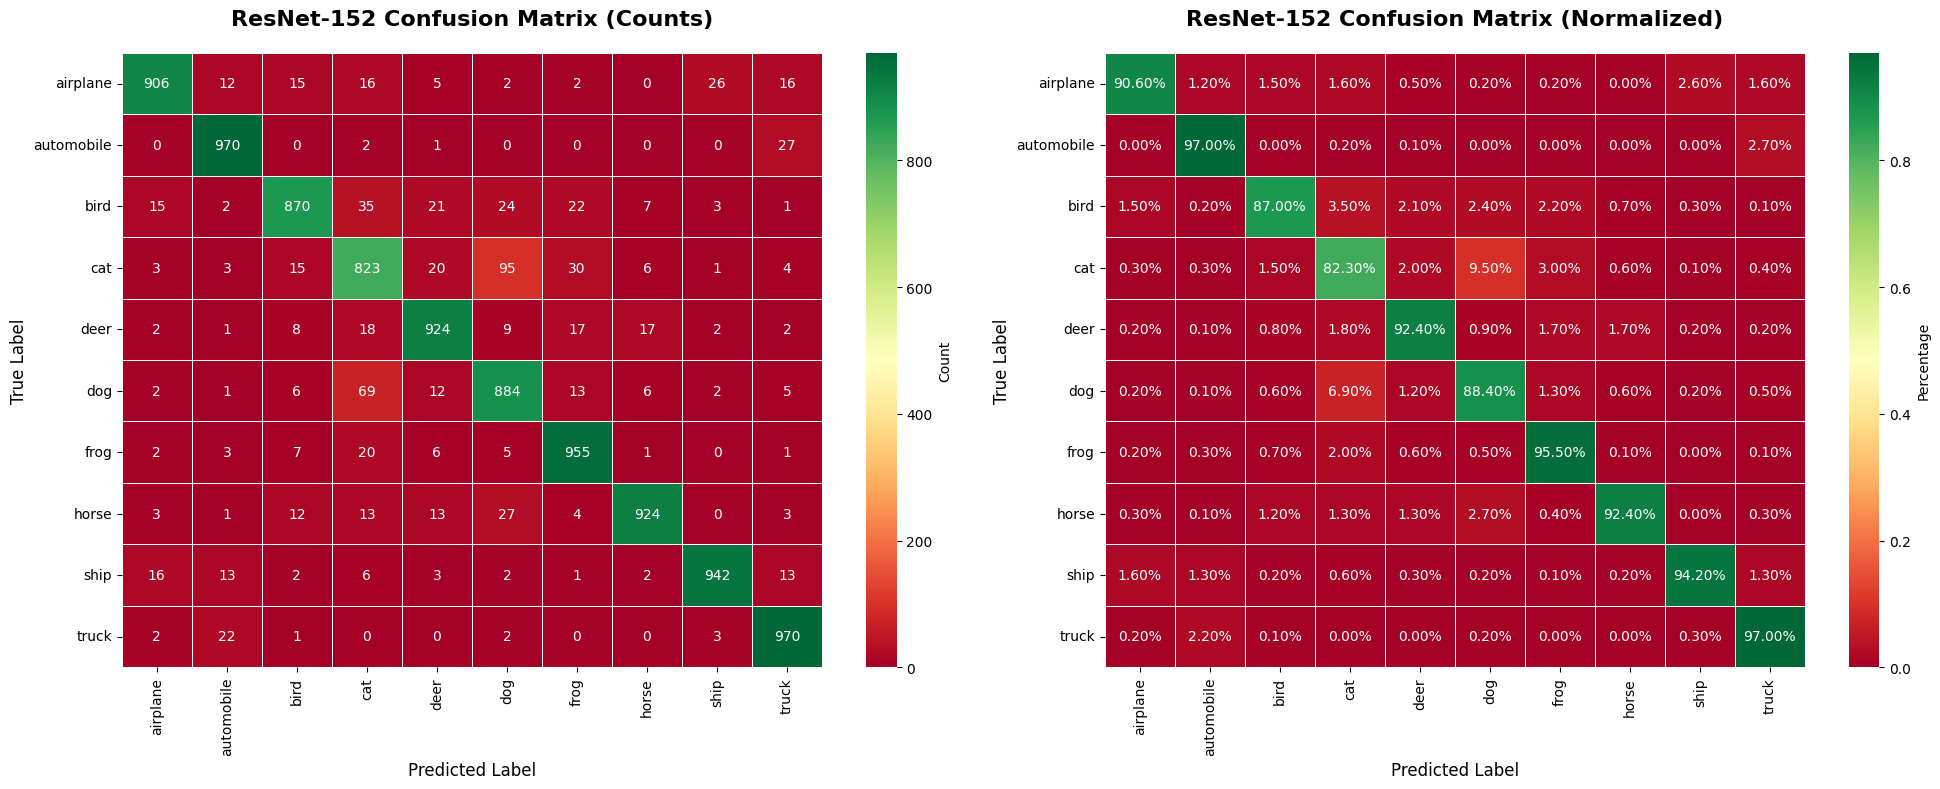


Detailed Classification Report
              precision    recall  f1-score   support

    airplane     0.9527    0.9060    0.9288      1000
  automobile     0.9436    0.9700    0.9566      1000
        bird     0.9295    0.8700    0.8988      1000
         cat     0.8214    0.8230    0.8222      1000
        deer     0.9194    0.9240    0.9217      1000
         dog     0.8419    0.8840    0.8624      1000
        frog     0.9148    0.9550    0.9344      1000
       horse     0.9595    0.9240    0.9414      1000
        ship     0.9622    0.9420    0.9520      1000
       truck     0.9309    0.9700    0.9500      1000

    accuracy                         0.9168     10000
   macro avg     0.9176    0.9168    0.9168     10000
weighted avg     0.9176    0.9168    0.9168     10000


Cohen's Kappa Score: 0.9076


In [12]:
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot enhanced confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Absolute counts
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn', ax=axes[0],
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'}, linewidths=0.5)
axes[0].set_title('ResNet-152 Confusion Matrix (Counts)', 
                  fontsize=16, fontweight='bold', pad=20)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Normalized (percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn', ax=axes[1],
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Percentage'}, linewidths=0.5)
axes[1].set_title('ResNet-152 Confusion Matrix (Normalized)', 
                  fontsize=16, fontweight='bold', pad=20)
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.savefig('resnet152_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Classification report
print("\n" + "=" * 80)
print("Detailed Classification Report")
print("=" * 80)
print(classification_report(true_classes, predicted_classes, 
                          target_names=class_names, digits=4))

# Cohen's Kappa Score
kappa = cohen_kappa_score(true_classes, predicted_classes)
print(f"\nCohen's Kappa Score: {kappa:.4f}")

# Block 13: Comprehensive Per-Class Analysis


In [13]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate detailed metrics
precision, recall, f1, support = precision_recall_fscore_support(
    true_classes, predicted_classes, average=None
)

# Per-class confidence analysis
class_confidences = {i: [] for i in range(10)}
class_correct_conf = {i: [] for i in range(10)}
class_incorrect_conf = {i: [] for i in range(10)}

for i in range(len(predictions)):
    true_label = true_classes[i]
    pred_label = predicted_classes[i]
    confidence = predictions[i][pred_label]
    
    class_confidences[true_label].append(confidence)
    if pred_label == true_label:
        class_correct_conf[true_label].append(confidence)
    else:
        class_incorrect_conf[true_label].append(confidence)

# Print comprehensive analysis
print("\n" + "=" * 110)
print("Comprehensive Per-Class Analysis - ResNet-152")
print("=" * 110)
print(f"{'Class':<12} {'Acc':<8} {'Prec':<8} {'Rec':<8} {'F1':<8} {'Supp':<8} "
      f"{'Avg Conf':<12} {'Corr Conf':<12} {'Incorr Conf':<12}")
print("-" * 110)

for i in range(10):
    class_mask = (true_classes == i)
    class_acc = np.mean(predicted_classes[class_mask] == true_classes[class_mask]) * 100
    avg_conf = np.mean(class_confidences[i]) * 100
    corr_conf = np.mean(class_correct_conf[i]) * 100 if class_correct_conf[i] else 0
    incorr_conf = np.mean(class_incorrect_conf[i]) * 100 if class_incorrect_conf[i] else 0
    
    print(f"{class_names[i]:<12} {class_acc:>6.2f}% {precision[i]:>6.4f} "
          f"{recall[i]:>6.4f} {f1[i]:>6.4f} {support[i]:>6}   "
          f"{avg_conf:>6.2f}%      {corr_conf:>6.2f}%       {incorr_conf:>6.2f}%")

print("=" * 110)

# Overall statistics
print(f"\nOverall Statistics:")
print(f"  Macro Avg Precision: {np.mean(precision):.4f}")
print(f"  Macro Avg Recall:    {np.mean(recall):.4f}")
print(f"  Macro Avg F1-Score:  {np.mean(f1):.4f}")
print(f"  Weighted Avg F1:     {np.average(f1, weights=support):.4f}")


Comprehensive Per-Class Analysis - ResNet-152
Class        Acc      Prec     Rec      F1       Supp     Avg Conf     Corr Conf    Incorr Conf 
--------------------------------------------------------------------------------------------------------------
airplane      90.60% 0.9527 0.9060 0.9288   1000    87.29%       89.13%        69.56%
automobile    97.00% 0.9436 0.9700 0.9566   1000    90.36%       90.68%        80.25%
bird          87.00% 0.9295 0.8700 0.8988   1000    85.97%       87.99%        72.46%
cat           82.30% 0.8214 0.8230 0.8222   1000    83.93%       86.42%        72.36%
deer          92.40% 0.9194 0.9240 0.9217   1000    88.29%       89.77%        70.35%
dog           88.40% 0.8419 0.8840 0.8624   1000    85.70%       87.63%        71.00%
frog          95.50% 0.9148 0.9550 0.9344   1000    89.23%       90.32%        66.09%
horse         92.40% 0.9595 0.9240 0.9414   1000    87.84%       89.47%        67.97%
ship          94.20% 0.9622 0.9420 0.9520   1000    88.79

# Block 14: Top-K Accuracy & Calibration Analysis


In [14]:
# Top-K accuracy
def calculate_topk_accuracy(y_true, y_pred, k):
    top_k_pred = np.argsort(y_pred, axis=1)[:, -k:]
    correct = sum([1 for i, true_label in enumerate(y_true) if true_label in top_k_pred[i]])
    return correct / len(y_true)

top1_acc = test_accuracy
top2_acc = calculate_topk_accuracy(true_classes, predictions, k=2)
top3_acc = calculate_topk_accuracy(true_classes, predictions, k=3)
top5_acc = calculate_topk_accuracy(true_classes, predictions, k=5)

print("\n" + "=" * 50)
print("Top-K Accuracy Analysis")
print("=" * 50)
print(f"Top-1 Accuracy: {top1_acc*100:.2f}%")
print(f"Top-2 Accuracy: {top2_acc*100:.2f}%")
print(f"Top-3 Accuracy: {top3_acc*100:.2f}%")
print(f"Top-5 Accuracy: {top5_acc*100:.2f}%")
print("=" * 50)

# Confidence calibration
confidence_bins = [0.0, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1.0]
max_confidences = np.max(predictions, axis=1)
accuracies_by_confidence = []

print("\nModel Calibration Analysis:")
print("=" * 60)
print(f"{'Confidence Range':<20} {'Accuracy':<15} {'Count':<10}")
print("-" * 60)

for i in range(len(confidence_bins)-1):
    lower, upper = confidence_bins[i], confidence_bins[i+1]
    mask = (max_confidences >= lower) & (max_confidences < upper)
    if np.sum(mask) > 0:
        acc = np.mean(predicted_classes[mask] == true_classes[mask]) * 100
        count = np.sum(mask)
        print(f"{lower:.2f} - {upper:.2f}        {acc:>6.2f}%         {count:>6}")
        accuracies_by_confidence.append((lower, upper, acc, count))

print("=" * 60)


Top-K Accuracy Analysis
Top-1 Accuracy: 91.68%
Top-2 Accuracy: 97.20%
Top-3 Accuracy: 98.76%
Top-5 Accuracy: 99.53%

Model Calibration Analysis:
Confidence Range     Accuracy        Count     
------------------------------------------------------------
0.00 - 0.50         38.94%            226
0.50 - 0.60         54.42%            226
0.60 - 0.70         59.76%            246
0.70 - 0.80         62.54%            355
0.80 - 0.90         81.75%           1348
0.90 - 0.95         98.51%           7591
0.95 - 1.00        100.00%              8


# Block 15: Save Final Model & Artifacts


In [15]:
# Save the complete model
print("\n" + "=" * 80)
print("Saving ResNet-152 Model and Artifacts")
print("=" * 80)

model.save('./models/resnet152_cifar10_final.keras')
print("✓ Final model saved: resnet152_cifar10_final.keras")

# Save model architecture
model_json = model.to_json()
with open('./models/resnet152_architecture.json', 'w') as json_file:
    json_file.write(model_json)
print("✓ Architecture saved: resnet152_architecture.json")

# Save weights
model.save_weights('./models/resnet152.weights.h5')
print("✓ Weights saved: resnet152.weights.h5")

# Save training history
import pickle
with open('./models/resnet152_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
print("✓ Training history saved: resnet152_history.pkl")

# Save evaluation results
eval_results = {
    'test_accuracy': float(test_accuracy),
    'test_loss': float(test_loss),
    'top1_accuracy': float(top1_acc),
    'top3_accuracy': float(top3_acc),
    'top5_accuracy': float(top5_acc),
    'per_class_accuracy': {class_names[i]: float(np.mean(predicted_classes[true_classes == i] == true_classes[true_classes == i]))
                          for i in range(10)},
    'confusion_matrix': cm.tolist(),
    'classification_report': classification_report(true_classes, predicted_classes, 
                                                   target_names=class_names, output_dict=True)
}

import json
with open('./models/resnet152_evaluation.json', 'w') as f:
    json.dump(eval_results, f, indent=2)
print("✓ Evaluation results saved: resnet152_evaluation.json")

print("\n" + "=" * 80)
print("All files saved successfully!")
print("=" * 80)
print("\nSaved files:")
print("  - resnet152_cifar10_final.keras (complete model)")
print("  - resnet152.weights.h5 (weights only)")
print("  - resnet152_architecture.json (architecture)")
print("  - resnet152_history.pkl (training history)")
print("  - resnet152_evaluation.json (evaluation metrics)")
print("=" * 80)


Saving ResNet-152 Model and Artifacts
✓ Final model saved: resnet152_cifar10_final.keras
✓ Architecture saved: resnet152_architecture.json
✓ Weights saved: resnet152.weights.h5
✓ Training history saved: resnet152_history.pkl
✓ Evaluation results saved: resnet152_evaluation.json

All files saved successfully!

Saved files:
  - resnet152_cifar10_final.keras (complete model)
  - resnet152.weights.h5 (weights only)
  - resnet152_architecture.json (architecture)
  - resnet152_history.pkl (training history)
  - resnet152_evaluation.json (evaluation metrics)
